In [1]:
import cv2
import numpy as np
import scipy.io as sio
import utils
from camera import Camera
import player

In [8]:
extrinsic_data = '../data/Calib/Extrinsics_PG1.npz'
camera_data = '../data/Calib/cameraParams_PG1.npz'
motion_capture_data = '../data/AMASS/F_amass_Subject_1.mat'
movement_number = 1
video_file = '../data/PG1/F_PG1_Subject_1_L1.avi'



camera = player.read_camera_params(extrinsic_data, camera_data)
motion_capture = player.read_motion_capture_data(motion_capture_data, movement_number)
image_points = utils.adapt_motion_data_for_video(motion_capture.joints, camera)

<IPython.core.display.Javascript object>


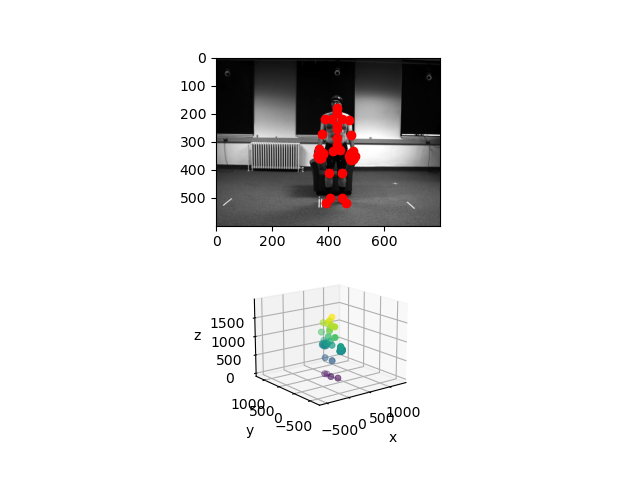

In [32]:
from mpl_toolkits import mplot3d

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import pylab
import imageio


fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)

frame = 0

filename =  '../data/PG1/F_PG1_Subject_1_L1.avi'
vid = imageio.get_reader(filename, 'ffmpeg')

image = vid.get_data(0)
ax1.imshow(image)
plt.show()


x_2d = image_points[frame, :, 0]
y_2d = image_points[frame, :, 1]
plt.plot(x_2d, y_2d, 'ro')
plt.show()


ax2 = fig.add_subplot(2, 1, 2, projection='3d')

# # ax = plt.axes(projection='3d')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z');

x = motion_capture.joints[0, :, 0]
y = motion_capture.joints[0, :, 1]
z = motion_capture.joints[0, :, 2]




r = 1 if np.max([x[0], y[0], z[0]]) <= 10 else 1000
xroot, yroot, zroot = x[0], y[0], z[0]

ax2.set_xlim3d([-r + xroot, r + xroot])
ax2.set_zlim3d([-r + zroot, r + zroot])
ax2.set_ylim3d([-r + yroot, r + yroot])

ax2.scatter(x, y, z, c=z, cmap='viridis', linewidth=0.5);


